
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [1]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "/content/project/input"


In [3]:
os.makedirs('./project/input', exist_ok=True)
os.makedirs('./project/output', exist_ok=True)
%cd project

/content/project/project


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/project/vinBigData/Chest X-ray(512).zip', 'r') as zip_ref:
  zip_ref.extractall('/content/project/input')

In [14]:
%cd /content/project/

/content/project


In [15]:
df = pd.read_csv('./input/train.csv')

In [16]:
df['class_id'].unique()

array([14,  3, 10, 11,  0, 13,  5,  8,  9,  7,  6,  4,  2,  1, 12])

In [17]:
# nofinding 제거 버전
df = pd.read_csv('./input/train.csv')
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

,image_id,class_id,x_min,y_min,x_max,y_max
6,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.092308,301.369863,406.892308,401.315068
7,9a5094b2563a1ef3ff50dc5c7ff71345,11,440.369231,378.958904,461.538462,436.602740
8,9a5094b2563a1ef3ff50dc5c7ff71345,12,440.369231,378.958904,461.538462,436.602740
9,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.338462,301.369863,407.876923,394.301370
10,9a5094b2563a1ef3ff50dc5c7ff71345,4,169.600000,287.780822,410.092308,386.410959
...,...,...,...,...,...,...
67774,52951d7de2485aba8ed62629eee4d254,10,67.333333,256.355556,85.111111,268.088889
67775,52951d7de2485aba8ed62629eee4d254,4,163.111111,279.288889,358.666667,336.355556
67848,1224f07d895107573588225f692e94f9,1,250.729412,161.922261,320.250980,223.434629
67849,1224f07d895107573588225f692e94f9,1,262.525490,155.590106,319.247059,221.399293


In [18]:
print("df Shape: "+str(df.shape))
print("No Of Classes: "+str(df["class_id"].nunique()))
df.sort_values(by='image_id').head(10)
len(df)


df Shape: (36096, 6)
No Of Classes: 14


36096

In [19]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    res['images'].append({
        'id': pic_name,
        'width': 512,
        'height':512,
        'file_name': pic_name+".png"
    })
      
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [20]:
random.seed(10)

train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 878


(3516, 878, 4394)

In [21]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/3516 [00:00<?, ?it/s]

In [22]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/878 [00:00<?, ?it/s]

## Environment setting

In [23]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

!pip show torch

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Name: torch
Version: 1.12.1+cu113
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions
Required-by: torchvision, torchtext, torchaudio, fastai


런타임 다시 시작하고 진행합니다.

In [24]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 32112, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 32112 (delta 0), reused 9 (delta 0), pack-reused 32097
Receiving objects: 100% (32112/32112), 41.01 MiB | 33.76 MiB/s, done.
Resolving deltas: 100% (23119/23119), done.


In [25]:
%cd ./mmdetection

/content/project/mmdetection


In [26]:
!pip install openmim
!mim install mmdet==2.22.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.6 MB/s 
     |████████████████████████████████| 237 kB 52.5 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 1.3 MB 16.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 728 kB 13.2 MB/s 
Saved /tmp/tmpj2r_ja0x/mmdet-2.22.0.tar.gz
Successfully downloaded mmdet
Get 'mim' extra requirements from `mminstall.txt` for mmdet 2.22.0: ['mmcv-full>=1.3.17'].
     |████████████████████████████████| 40.6 MB 13.7 MB/s 
     |████████████████████████████████| 190 kB 64.6 MB/s 
Using cached `mminstall.txt` for mmdet==2.22.0: 

=========

In [27]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.1+cu113 True
2.25.2
11.3
GCC 9.3


In [28]:
%pwd

'/content/project/mmdetection'

In [29]:
!mkdir checkpoints

In [30]:
%cd /content/project/mmdetection/checkpoints


/content/project/mmdetection/checkpoints


In [31]:
#   - Name: mask_rcnn_swin-t-p4-w7_fpn_ms-crop-3x_coco

!wget -c https://download.openmmlab.com/mmdetection/v2.0/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth \
      -O /content/project/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth

--2022-10-25 01:47:21--  https://download.openmmlab.com/mmdetection/v2.0/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.43
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191461353 (183M) [application/octet-stream]
Saving to: ‘/content/project/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth’

/content/project/mm 100%[===================>] 182.59M  7.83MB/s    in 21s     

2022-10-25 01:47:42 (8.80 MB/s) - ‘/content/project/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth’ saved [191461353/191461353]



https://blog.csdn.net/w9mysun/article/details/125327762

In [32]:
config = "/content/project/mmdetection/configs/swin/mask_rcnn_swin-t-p4-w7_fpn_1x_coco.py"
checkpoint = "/content/project/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth"

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [33]:
import mmcv
import matplotlib.pyplot as plt
import copy
import os.path as osp
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [34]:
!pip install mmcls


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 647 kB 30.4 MB/s 


In [41]:
from mmcv import Config
import mmcls
cfg = Config.fromfile(config)

In [42]:
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='SwinTransformer',
        embed_dims=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        with_cp=False,
        convert_weights=True,
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth'
        )),
    neck=dict(
        type='FPN',
        in_channels=[96, 192, 384, 768],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [43]:
from mmdet.apis import set_random_seed

base_path = '/content/project/input' # base_dir과 같습니다.

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/project/vinBigData/swin/1'

EPOCHS= 36


In [44]:
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"
valid_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"

train_img = "train" # 출력은 "train_100000"
valid_img = 'train'
test_img =  "test" # 출력은 "train_100000"



# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = valid_anno
cfg.data.val.img_prefix = valid_img

#test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img



cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 0

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head['num_classes'] =14

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

cfg.load_from = checkpoint
cfg.checkpoint_file = checkpoint
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = None


# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer = dict(type='AdamW', lr=0.0003, weight_decay=0.0001)
#cfg.optimizer.lr = 0.02 / 8 # 0.0025
# learning rate
cfg.lr_config.warmup = None

# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#COCO dataset은 mmdetection에서 mAP metric을 지원하지 않아 VOC로 테스트
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'


cfg.model.backbone.init_cfg.checkpoint =checkpoint
cfg.pretrained = checkpoint

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='SwinTransformer',
        embed_dims=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        with_cp=False,
        convert_weights=True,
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            '/content/project/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth'
        )),
    neck=dict(
        type='FPN',
        in_channels=[96, 192, 384, 768],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

In [ ]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))


In [ ]:
# train
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-10-23 14:34:53,961 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-23 14:34:54,001 - mmdet - INFO - load checkpoint from local path: /content/project/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_1x_coco_20210902_120937-9d6b7cfa.pth
2022-10-23 14:34:54,134 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([15, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([15]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([56, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the s

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-10-23 14:35:03,851 - mmdet - INFO - Epoch [1][10/440]	lr: 3.000e-04, eta: 4:15:56, time: 0.970, data_time: 0.361, memory: 14840, loss_rpn_cls: 0.2731, loss_rpn_bbox: 0.0706, loss_cls: 0.5168, acc: 93.7988, loss_bbox: 0.1736, loss: 1.0341
2022-10-23 14:35:11,543 - mmdet - INFO - Epoch [1][20/440]	lr: 3.000e-04, eta: 3:49:18, time: 0.769, data_time: 0.160, memory: 14840, loss_rpn_cls: 0.1576, loss_rpn_bbox: 0.0627, loss_cls: 0.3627, acc: 92.6978, loss_bbox: 0.2394, loss: 0.8224
2022-10-23 14:35:19,163 - mmdet - INFO - Epoch [1][30/440]	lr: 3.000e-04, eta: 3:39:41, time: 0.762, data_time: 0.158, memory: 14840, loss_rpn_cls: 0.1313, loss_rpn_bbox: 0.0589, loss_cls: 0.3785, acc: 91.5747, loss_bbox: 0.2962, loss: 0.8649
2022-10-23 14:35:26,744 - mmdet - INFO - Epoch [1][40/440]	lr: 3.000e-04, eta: 3:34:34, time: 0.758, data_time: 0.157, memory: 14840, loss_rpn_cls: 0.1324, loss_rpn_bbox: 0.0529, loss_cls: 0.3497, acc: 92.1753, loss_bbox: 0.2815, loss: 0.8165
2022-10-23 14:35:34,379 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 18.3 task/s, elapsed: 48s, ETA:     0s

2022-10-23 14:41:21,984 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.29s).
Accumulating evaluation results...


2022-10-23 14:41:28,105 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.169
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.174
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.081
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.43s).


2022-10-23 14:41:37,825 - mmdet - INFO - Epoch [2][10/440]	lr: 3.000e-04, eta: 3:17:12, time: 0.964, data_time: 0.361, memory: 14840, loss_rpn_cls: 0.0552, loss_rpn_bbox: 0.0389, loss_cls: 0.3160, acc: 90.9863, loss_bbox: 0.3394, loss: 0.7495
2022-10-23 14:41:45,483 - mmdet - INFO - Epoch [2][20/440]	lr: 3.000e-04, eta: 3:17:04, time: 0.766, data_time: 0.163, memory: 14840, loss_rpn_cls: 0.0471, loss_rpn_bbox: 0.0439, loss_cls: 0.3143, acc: 91.0352, loss_bbox: 0.3285, loss: 0.7339
2022-10-23 14:41:53,160 - mmdet - INFO - Epoch [2][30/440]	lr: 3.000e-04, eta: 3:16:56, time: 0.768, data_time: 0.167, memory: 14840, loss_rpn_cls: 0.0486, loss_rpn_bbox: 0.0430, loss_cls: 0.3052, acc: 91.1157, loss_bbox: 0.3464, loss: 0.7432
2022-10-23 14:42:00,769 - mmdet - INFO - Epoch [2][40/440]	lr: 3.000e-04, eta: 3:16:45, time: 0.761, data_time: 0.161, memory: 14840, loss_rpn_cls: 0.0554, loss_rpn_bbox: 0.0452, loss_cls: 0.3260, acc: 90.2026, loss_bbox: 0.3629, loss: 0.7895
2022-10-23 14:42:08,331 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 14:47:58,367 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.72s).
Accumulating evaluation results...


2022-10-23 14:48:03,618 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.189
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.19s).


2022-10-23 14:48:13,351 - mmdet - INFO - Epoch [3][10/440]	lr: 3.000e-04, eta: 3:11:28, time: 0.966, data_time: 0.364, memory: 14842, loss_rpn_cls: 0.0525, loss_rpn_bbox: 0.0459, loss_cls: 0.3386, acc: 90.2515, loss_bbox: 0.3618, loss: 0.7988
2022-10-23 14:48:21,011 - mmdet - INFO - Epoch [3][20/440]	lr: 3.000e-04, eta: 3:11:20, time: 0.766, data_time: 0.165, memory: 14842, loss_rpn_cls: 0.0452, loss_rpn_bbox: 0.0458, loss_cls: 0.2884, acc: 91.4917, loss_bbox: 0.3137, loss: 0.6932
2022-10-23 14:48:28,630 - mmdet - INFO - Epoch [3][30/440]	lr: 3.000e-04, eta: 3:11:11, time: 0.762, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0566, loss_rpn_bbox: 0.0444, loss_cls: 0.3260, acc: 90.6689, loss_bbox: 0.3490, loss: 0.7761
2022-10-23 14:48:36,254 - mmdet - INFO - Epoch [3][40/440]	lr: 3.000e-04, eta: 3:11:03, time: 0.762, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0427, loss_rpn_bbox: 0.0395, loss_cls: 0.3176, acc: 90.5029, loss_bbox: 0.3396, loss: 0.7394
2022-10-23 14:48:43,848 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 14:54:33,312 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.71s).
Accumulating evaluation results...


2022-10-23 14:54:38,460 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.228
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.11s).


2022-10-23 14:54:48,161 - mmdet - INFO - Epoch [4][10/440]	lr: 3.000e-04, eta: 3:05:44, time: 0.963, data_time: 0.359, memory: 14842, loss_rpn_cls: 0.0358, loss_rpn_bbox: 0.0438, loss_cls: 0.3165, acc: 90.6714, loss_bbox: 0.3263, loss: 0.7224
2022-10-23 14:54:55,792 - mmdet - INFO - Epoch [4][20/440]	lr: 3.000e-04, eta: 3:05:35, time: 0.763, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0407, loss_rpn_bbox: 0.0415, loss_cls: 0.3312, acc: 90.2954, loss_bbox: 0.3604, loss: 0.7738
2022-10-23 14:55:03,425 - mmdet - INFO - Epoch [4][30/440]	lr: 3.000e-04, eta: 3:05:27, time: 0.763, data_time: 0.166, memory: 14842, loss_rpn_cls: 0.0317, loss_rpn_bbox: 0.0411, loss_cls: 0.2882, acc: 90.9180, loss_bbox: 0.3316, loss: 0.6925
2022-10-23 14:55:11,079 - mmdet - INFO - Epoch [4][40/440]	lr: 3.000e-04, eta: 3:05:19, time: 0.765, data_time: 0.164, memory: 14842, loss_rpn_cls: 0.0416, loss_rpn_bbox: 0.0460, loss_cls: 0.3003, acc: 91.1060, loss_bbox: 0.3400, loss: 0.7279
2022-10-23 14:55:18,722 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 15:01:08,254 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.22s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.57s).
Accumulating evaluation results...


2022-10-23 15:01:13,517 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.235
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.217
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.197
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.34s).


2022-10-23 15:01:23,293 - mmdet - INFO - Epoch [5][10/440]	lr: 3.000e-04, eta: 3:00:06, time: 0.970, data_time: 0.364, memory: 14842, loss_rpn_cls: 0.0382, loss_rpn_bbox: 0.0411, loss_cls: 0.2888, acc: 90.6445, loss_bbox: 0.3355, loss: 0.7037
2022-10-23 15:01:30,955 - mmdet - INFO - Epoch [5][20/440]	lr: 3.000e-04, eta: 2:59:58, time: 0.766, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0453, loss_rpn_bbox: 0.0430, loss_cls: 0.3190, acc: 90.0586, loss_bbox: 0.3470, loss: 0.7542
2022-10-23 15:01:38,531 - mmdet - INFO - Epoch [5][30/440]	lr: 3.000e-04, eta: 2:59:50, time: 0.758, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0403, loss_rpn_bbox: 0.0521, loss_cls: 0.3070, acc: 90.6299, loss_bbox: 0.3670, loss: 0.7665
2022-10-23 15:01:46,159 - mmdet - INFO - Epoch [5][40/440]	lr: 3.000e-04, eta: 2:59:41, time: 0.763, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0366, loss_rpn_bbox: 0.0382, loss_cls: 0.2857, acc: 91.1475, loss_bbox: 0.3228, loss: 0.6833
2022-10-23 15:01:53,813 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 15:07:43,950 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.38s).
Accumulating evaluation results...


2022-10-23 15:07:48,498 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.242
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.02s).


2022-10-23 15:07:58,208 - mmdet - INFO - Epoch [6][10/440]	lr: 3.000e-04, eta: 2:54:31, time: 0.964, data_time: 0.361, memory: 14842, loss_rpn_cls: 0.0308, loss_rpn_bbox: 0.0408, loss_cls: 0.2751, acc: 90.9766, loss_bbox: 0.3324, loss: 0.6790
2022-10-23 15:08:05,823 - mmdet - INFO - Epoch [6][20/440]	lr: 3.000e-04, eta: 2:54:23, time: 0.761, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0341, loss_rpn_bbox: 0.0345, loss_cls: 0.2960, acc: 90.3979, loss_bbox: 0.3326, loss: 0.6972
2022-10-23 15:08:13,414 - mmdet - INFO - Epoch [6][30/440]	lr: 3.000e-04, eta: 2:54:15, time: 0.759, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0341, loss_rpn_bbox: 0.0397, loss_cls: 0.2755, acc: 91.2939, loss_bbox: 0.3238, loss: 0.6731
2022-10-23 15:08:21,024 - mmdet - INFO - Epoch [6][40/440]	lr: 3.000e-04, eta: 2:54:07, time: 0.761, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0378, loss_rpn_bbox: 0.0379, loss_cls: 0.2424, acc: 92.3047, loss_bbox: 0.2955, loss: 0.6136
2022-10-23 15:08:28,618 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 15:14:17,557 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.84s).
Accumulating evaluation results...


2022-10-23 15:14:22,954 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.21s).


2022-10-23 15:14:32,755 - mmdet - INFO - Epoch [7][10/440]	lr: 3.000e-04, eta: 2:48:47, time: 0.971, data_time: 0.364, memory: 14842, loss_rpn_cls: 0.0319, loss_rpn_bbox: 0.0447, loss_cls: 0.3074, acc: 89.7754, loss_bbox: 0.3840, loss: 0.7679
2022-10-23 15:14:40,405 - mmdet - INFO - Epoch [7][20/440]	lr: 3.000e-04, eta: 2:48:39, time: 0.765, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0303, loss_rpn_bbox: 0.0359, loss_cls: 0.2849, acc: 91.1377, loss_bbox: 0.3172, loss: 0.6683
2022-10-23 15:14:48,123 - mmdet - INFO - Epoch [7][30/440]	lr: 3.000e-04, eta: 2:48:32, time: 0.772, data_time: 0.166, memory: 14842, loss_rpn_cls: 0.0296, loss_rpn_bbox: 0.0403, loss_cls: 0.2533, acc: 91.4404, loss_bbox: 0.3204, loss: 0.6436
2022-10-23 15:14:55,867 - mmdet - INFO - Epoch [7][40/440]	lr: 3.000e-04, eta: 2:48:24, time: 0.774, data_time: 0.168, memory: 14842, loss_rpn_cls: 0.0325, loss_rpn_bbox: 0.0478, loss_cls: 0.3045, acc: 89.8462, loss_bbox: 0.3642, loss: 0.7490
2022-10-23 15:15:03,539 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 15:20:53,990 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.09s).
Accumulating evaluation results...


2022-10-23 15:20:58,253 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.241
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.90s).


2022-10-23 15:21:07,966 - mmdet - INFO - Epoch [8][10/440]	lr: 3.000e-04, eta: 2:43:13, time: 0.965, data_time: 0.363, memory: 14842, loss_rpn_cls: 0.0339, loss_rpn_bbox: 0.0419, loss_cls: 0.2799, acc: 90.9570, loss_bbox: 0.3379, loss: 0.6936
2022-10-23 15:21:15,655 - mmdet - INFO - Epoch [8][20/440]	lr: 3.000e-04, eta: 2:43:05, time: 0.769, data_time: 0.166, memory: 14842, loss_rpn_cls: 0.0239, loss_rpn_bbox: 0.0409, loss_cls: 0.2733, acc: 90.6006, loss_bbox: 0.3424, loss: 0.6804
2022-10-23 15:21:23,329 - mmdet - INFO - Epoch [8][30/440]	lr: 3.000e-04, eta: 2:42:57, time: 0.767, data_time: 0.166, memory: 14842, loss_rpn_cls: 0.0331, loss_rpn_bbox: 0.0391, loss_cls: 0.2716, acc: 90.9448, loss_bbox: 0.3306, loss: 0.6744
2022-10-23 15:21:30,957 - mmdet - INFO - Epoch [8][40/440]	lr: 3.000e-04, eta: 2:42:50, time: 0.763, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0315, loss_rpn_bbox: 0.0432, loss_cls: 0.2702, acc: 91.1401, loss_bbox: 0.3183, loss: 0.6632
2022-10-23 15:21:38,605 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 15:27:28,536 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.95s).
Accumulating evaluation results...


2022-10-23 15:27:34,117 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.259
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.251
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.132
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=1.28s).


2022-10-23 15:27:43,820 - mmdet - INFO - Epoch [9][10/440]	lr: 3.000e-05, eta: 2:37:34, time: 0.962, data_time: 0.358, memory: 14842, loss_rpn_cls: 0.0231, loss_rpn_bbox: 0.0358, loss_cls: 0.2510, acc: 91.6431, loss_bbox: 0.3129, loss: 0.6228
2022-10-23 15:27:51,454 - mmdet - INFO - Epoch [9][20/440]	lr: 3.000e-05, eta: 2:37:26, time: 0.763, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0219, loss_rpn_bbox: 0.0385, loss_cls: 0.2547, acc: 91.2402, loss_bbox: 0.3088, loss: 0.6239
2022-10-23 15:27:59,061 - mmdet - INFO - Epoch [9][30/440]	lr: 3.000e-05, eta: 2:37:18, time: 0.761, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0227, loss_rpn_bbox: 0.0338, loss_cls: 0.2650, acc: 91.0864, loss_bbox: 0.3201, loss: 0.6416
2022-10-23 15:28:06,731 - mmdet - INFO - Epoch [9][40/440]	lr: 3.000e-05, eta: 2:37:10, time: 0.767, data_time: 0.165, memory: 14842, loss_rpn_cls: 0.0238, loss_rpn_bbox: 0.0362, loss_cls: 0.2817, acc: 90.4639, loss_bbox: 0.3403, loss: 0.6820
2022-10-23 15:28:14,375 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 15:34:04,867 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.17s).
Accumulating evaluation results...


2022-10-23 15:34:09,248 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.92s).


2022-10-23 15:34:19,005 - mmdet - INFO - Epoch [10][10/440]	lr: 3.000e-05, eta: 2:31:57, time: 0.969, data_time: 0.363, memory: 14842, loss_rpn_cls: 0.0234, loss_rpn_bbox: 0.0463, loss_cls: 0.2585, acc: 91.0156, loss_bbox: 0.3440, loss: 0.6721
2022-10-23 15:34:26,729 - mmdet - INFO - Epoch [10][20/440]	lr: 3.000e-05, eta: 2:31:50, time: 0.772, data_time: 0.168, memory: 14842, loss_rpn_cls: 0.0144, loss_rpn_bbox: 0.0317, loss_cls: 0.2269, acc: 92.2778, loss_bbox: 0.2973, loss: 0.5704
2022-10-23 15:34:34,465 - mmdet - INFO - Epoch [10][30/440]	lr: 3.000e-05, eta: 2:31:42, time: 0.774, data_time: 0.167, memory: 14842, loss_rpn_cls: 0.0149, loss_rpn_bbox: 0.0293, loss_cls: 0.2075, acc: 92.6611, loss_bbox: 0.2790, loss: 0.5306
2022-10-23 15:34:42,209 - mmdet - INFO - Epoch [10][40/440]	lr: 3.000e-05, eta: 2:31:35, time: 0.774, data_time: 0.171, memory: 14842, loss_rpn_cls: 0.0149, loss_rpn_bbox: 0.0378, loss_cls: 0.2461, acc: 91.7212, loss_bbox: 0.3347, loss: 0.6335
2022-10-23 15:34:49,816 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.6 task/s, elapsed: 50s, ETA:     0s

2022-10-23 15:40:40,549 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.93s).
Accumulating evaluation results...


2022-10-23 15:40:44,376 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.281
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.115
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-23 15:40:54,114 - mmdet - INFO - Epoch [11][10/440]	lr: 3.000e-05, eta: 2:26:22, time: 0.968, data_time: 0.362, memory: 14842, loss_rpn_cls: 0.0155, loss_rpn_bbox: 0.0356, loss_cls: 0.2132, acc: 92.7515, loss_bbox: 0.2797, loss: 0.5440
2022-10-23 15:41:01,796 - mmdet - INFO - Epoch [11][20/440]	lr: 3.000e-05, eta: 2:26:14, time: 0.768, data_time: 0.165, memory: 14842, loss_rpn_cls: 0.0175, loss_rpn_bbox: 0.0419, loss_cls: 0.2528, acc: 91.0474, loss_bbox: 0.3350, loss: 0.6472
2022-10-23 15:41:09,488 - mmdet - INFO - Epoch [11][30/440]	lr: 3.000e-05, eta: 2:26:06, time: 0.769, data_time: 0.166, memory: 14842, loss_rpn_cls: 0.0172, loss_rpn_bbox: 0.0374, loss_cls: 0.2435, acc: 91.4722, loss_bbox: 0.3206, loss: 0.6188
2022-10-23 15:41:17,147 - mmdet - INFO - Epoch [11][40/440]	lr: 3.000e-05, eta: 2:25:59, time: 0.766, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0155, loss_rpn_bbox: 0.0336, loss_cls: 0.2539, acc: 90.9668, loss_bbox: 0.3611, loss: 0.6641
2022-10-23 15:41:24,835 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 15:47:14,858 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.07s).
Accumulating evaluation results...


2022-10-23 15:47:19,094 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.88s).


2022-10-23 15:47:28,786 - mmdet - INFO - Epoch [12][10/440]	lr: 3.000e-06, eta: 2:20:44, time: 0.963, data_time: 0.358, memory: 14842, loss_rpn_cls: 0.0112, loss_rpn_bbox: 0.0374, loss_cls: 0.2187, acc: 92.1387, loss_bbox: 0.3218, loss: 0.5891
2022-10-23 15:47:36,423 - mmdet - INFO - Epoch [12][20/440]	lr: 3.000e-06, eta: 2:20:36, time: 0.764, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0143, loss_rpn_bbox: 0.0413, loss_cls: 0.2394, acc: 91.2915, loss_bbox: 0.3290, loss: 0.6240
2022-10-23 15:47:44,016 - mmdet - INFO - Epoch [12][30/440]	lr: 3.000e-06, eta: 2:20:29, time: 0.759, data_time: 0.158, memory: 14842, loss_rpn_cls: 0.0125, loss_rpn_bbox: 0.0324, loss_cls: 0.2221, acc: 92.3608, loss_bbox: 0.2792, loss: 0.5462
2022-10-23 15:47:51,624 - mmdet - INFO - Epoch [12][40/440]	lr: 3.000e-06, eta: 2:20:21, time: 0.761, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0133, loss_rpn_bbox: 0.0325, loss_cls: 0.2084, acc: 92.5342, loss_bbox: 0.2890, loss: 0.5432
2022-10-23 15:47:59,241 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 15:53:48,531 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.92s).
Accumulating evaluation results...


2022-10-23 15:53:52,397 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.84s).


2022-10-23 15:54:02,083 - mmdet - INFO - Epoch [13][10/440]	lr: 3.000e-06, eta: 2:15:05, time: 0.963, data_time: 0.359, memory: 14842, loss_rpn_cls: 0.0146, loss_rpn_bbox: 0.0330, loss_cls: 0.2128, acc: 92.6196, loss_bbox: 0.2952, loss: 0.5557
2022-10-23 15:54:09,696 - mmdet - INFO - Epoch [13][20/440]	lr: 3.000e-06, eta: 2:14:57, time: 0.761, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0156, loss_rpn_bbox: 0.0316, loss_cls: 0.2182, acc: 92.7271, loss_bbox: 0.3085, loss: 0.5739
2022-10-23 15:54:17,321 - mmdet - INFO - Epoch [13][30/440]	lr: 3.000e-06, eta: 2:14:49, time: 0.762, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0115, loss_rpn_bbox: 0.0342, loss_cls: 0.2329, acc: 91.5918, loss_bbox: 0.3306, loss: 0.6092
2022-10-23 15:54:24,886 - mmdet - INFO - Epoch [13][40/440]	lr: 3.000e-06, eta: 2:14:41, time: 0.757, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0107, loss_rpn_bbox: 0.0280, loss_cls: 0.2079, acc: 92.3560, loss_bbox: 0.2924, loss: 0.5390
2022-10-23 15:54:32,502 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 16:00:22,460 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.89s).
Accumulating evaluation results...


2022-10-23 16:00:26,290 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.83s).


2022-10-23 16:00:35,986 - mmdet - INFO - Epoch [14][10/440]	lr: 3.000e-06, eta: 2:09:26, time: 0.963, data_time: 0.359, memory: 14842, loss_rpn_cls: 0.0120, loss_rpn_bbox: 0.0350, loss_cls: 0.2439, acc: 91.7334, loss_bbox: 0.3291, loss: 0.6201
2022-10-23 16:00:43,626 - mmdet - INFO - Epoch [14][20/440]	lr: 3.000e-06, eta: 2:09:18, time: 0.764, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0147, loss_rpn_bbox: 0.0398, loss_cls: 0.2178, acc: 92.2412, loss_bbox: 0.3152, loss: 0.5875
2022-10-23 16:00:51,223 - mmdet - INFO - Epoch [14][30/440]	lr: 3.000e-06, eta: 2:09:11, time: 0.760, data_time: 0.158, memory: 14842, loss_rpn_cls: 0.0136, loss_rpn_bbox: 0.0319, loss_cls: 0.1895, acc: 92.9175, loss_bbox: 0.2825, loss: 0.5175
2022-10-23 16:00:58,914 - mmdet - INFO - Epoch [14][40/440]	lr: 3.000e-06, eta: 2:09:03, time: 0.769, data_time: 0.165, memory: 14842, loss_rpn_cls: 0.0119, loss_rpn_bbox: 0.0342, loss_cls: 0.2102, acc: 92.4072, loss_bbox: 0.3003, loss: 0.5566
2022-10-23 16:01:06,595 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.4 task/s, elapsed: 50s, ETA:     0s

2022-10-23 16:06:56,958 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.96s).
Accumulating evaluation results...


2022-10-23 16:07:00,859 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.84s).


2022-10-23 16:07:10,608 - mmdet - INFO - Epoch [15][10/440]	lr: 3.000e-06, eta: 2:03:47, time: 0.969, data_time: 0.363, memory: 14842, loss_rpn_cls: 0.0121, loss_rpn_bbox: 0.0358, loss_cls: 0.2555, acc: 90.6201, loss_bbox: 0.3521, loss: 0.6555
2022-10-23 16:07:18,248 - mmdet - INFO - Epoch [15][20/440]	lr: 3.000e-06, eta: 2:03:40, time: 0.764, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0144, loss_rpn_bbox: 0.0346, loss_cls: 0.2229, acc: 91.9531, loss_bbox: 0.3215, loss: 0.5933
2022-10-23 16:07:25,912 - mmdet - INFO - Epoch [15][30/440]	lr: 3.000e-06, eta: 2:03:32, time: 0.766, data_time: 0.164, memory: 14842, loss_rpn_cls: 0.0108, loss_rpn_bbox: 0.0295, loss_cls: 0.2269, acc: 91.9409, loss_bbox: 0.3087, loss: 0.5759
2022-10-23 16:07:33,569 - mmdet - INFO - Epoch [15][40/440]	lr: 3.000e-06, eta: 2:03:24, time: 0.766, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0104, loss_rpn_bbox: 0.0357, loss_cls: 0.2000, acc: 92.7856, loss_bbox: 0.2940, loss: 0.5401
2022-10-23 16:07:41,193 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 16:13:31,082 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.94s).
Accumulating evaluation results...


2022-10-23 16:13:34,977 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.164
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.83s).


2022-10-23 16:13:44,769 - mmdet - INFO - Epoch [16][10/440]	lr: 3.000e-06, eta: 1:58:09, time: 0.973, data_time: 0.366, memory: 14842, loss_rpn_cls: 0.0121, loss_rpn_bbox: 0.0369, loss_cls: 0.2198, acc: 92.2363, loss_bbox: 0.3262, loss: 0.5951
2022-10-23 16:13:52,393 - mmdet - INFO - Epoch [16][20/440]	lr: 3.000e-06, eta: 1:58:02, time: 0.762, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0131, loss_rpn_bbox: 0.0332, loss_cls: 0.1973, acc: 92.8125, loss_bbox: 0.3049, loss: 0.5485
2022-10-23 16:14:00,009 - mmdet - INFO - Epoch [16][30/440]	lr: 3.000e-06, eta: 1:57:54, time: 0.762, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0145, loss_rpn_bbox: 0.0298, loss_cls: 0.1859, acc: 93.4668, loss_bbox: 0.2674, loss: 0.4977
2022-10-23 16:14:07,645 - mmdet - INFO - Epoch [16][40/440]	lr: 3.000e-06, eta: 1:57:46, time: 0.764, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0132, loss_rpn_bbox: 0.0316, loss_cls: 0.2323, acc: 91.9214, loss_bbox: 0.3106, loss: 0.5878
2022-10-23 16:14:15,311 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 16:20:05,408 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.81s).
Accumulating evaluation results...


2022-10-23 16:20:09,273 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.282
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-23 16:20:19,028 - mmdet - INFO - Epoch [17][10/440]	lr: 3.000e-06, eta: 1:52:32, time: 0.969, data_time: 0.364, memory: 14842, loss_rpn_cls: 0.0146, loss_rpn_bbox: 0.0338, loss_cls: 0.2087, acc: 92.6904, loss_bbox: 0.2912, loss: 0.5483
2022-10-23 16:20:26,673 - mmdet - INFO - Epoch [17][20/440]	lr: 3.000e-06, eta: 1:52:24, time: 0.764, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0111, loss_rpn_bbox: 0.0310, loss_cls: 0.2151, acc: 92.1436, loss_bbox: 0.3007, loss: 0.5579
2022-10-23 16:20:34,287 - mmdet - INFO - Epoch [17][30/440]	lr: 3.000e-06, eta: 1:52:16, time: 0.761, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0123, loss_rpn_bbox: 0.0288, loss_cls: 0.2163, acc: 92.4341, loss_bbox: 0.3014, loss: 0.5587
2022-10-23 16:20:41,934 - mmdet - INFO - Epoch [17][40/440]	lr: 3.000e-06, eta: 1:52:08, time: 0.765, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0135, loss_rpn_bbox: 0.0315, loss_cls: 0.2116, acc: 92.7466, loss_bbox: 0.3047, loss: 0.5612
2022-10-23 16:20:49,579 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 49s, ETA:     0s

2022-10-23 16:26:39,575 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.88s).
Accumulating evaluation results...


2022-10-23 16:26:43,533 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.82s).


2022-10-23 16:26:53,205 - mmdet - INFO - Epoch [18][10/440]	lr: 3.000e-06, eta: 1:46:53, time: 0.961, data_time: 0.358, memory: 14842, loss_rpn_cls: 0.0126, loss_rpn_bbox: 0.0309, loss_cls: 0.1945, acc: 92.7148, loss_bbox: 0.3123, loss: 0.5503
2022-10-23 16:27:00,808 - mmdet - INFO - Epoch [18][20/440]	lr: 3.000e-06, eta: 1:46:45, time: 0.760, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0115, loss_rpn_bbox: 0.0274, loss_cls: 0.1970, acc: 93.0811, loss_bbox: 0.2776, loss: 0.5135
2022-10-23 16:27:08,392 - mmdet - INFO - Epoch [18][30/440]	lr: 3.000e-06, eta: 1:46:37, time: 0.758, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0143, loss_rpn_bbox: 0.0317, loss_cls: 0.1886, acc: 93.5425, loss_bbox: 0.2592, loss: 0.4938
2022-10-23 16:27:16,051 - mmdet - INFO - Epoch [18][40/440]	lr: 3.000e-06, eta: 1:46:30, time: 0.766, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0119, loss_rpn_bbox: 0.0299, loss_cls: 0.2194, acc: 92.1045, loss_bbox: 0.2990, loss: 0.5602
2022-10-23 16:27:23,725 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 16:33:12,007 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.01s).
Accumulating evaluation results...


2022-10-23 16:33:16,149 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.85s).


2022-10-23 16:33:25,903 - mmdet - INFO - Epoch [19][10/440]	lr: 3.000e-06, eta: 1:41:14, time: 0.969, data_time: 0.364, memory: 14842, loss_rpn_cls: 0.0122, loss_rpn_bbox: 0.0299, loss_cls: 0.1968, acc: 92.8369, loss_bbox: 0.3045, loss: 0.5435
2022-10-23 16:33:33,495 - mmdet - INFO - Epoch [19][20/440]	lr: 3.000e-06, eta: 1:41:06, time: 0.759, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0097, loss_rpn_bbox: 0.0317, loss_cls: 0.2099, acc: 92.5903, loss_bbox: 0.2954, loss: 0.5467
2022-10-23 16:33:41,061 - mmdet - INFO - Epoch [19][30/440]	lr: 3.000e-06, eta: 1:40:59, time: 0.757, data_time: 0.155, memory: 14842, loss_rpn_cls: 0.0084, loss_rpn_bbox: 0.0342, loss_cls: 0.2089, acc: 92.3901, loss_bbox: 0.3032, loss: 0.5548
2022-10-23 16:33:48,634 - mmdet - INFO - Epoch [19][40/440]	lr: 3.000e-06, eta: 1:40:51, time: 0.757, data_time: 0.158, memory: 14842, loss_rpn_cls: 0.0162, loss_rpn_bbox: 0.0305, loss_cls: 0.2035, acc: 92.5879, loss_bbox: 0.2959, loss: 0.5463
2022-10-23 16:33:56,182 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 16:39:44,047 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.92s).
Accumulating evaluation results...


2022-10-23 16:39:47,907 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.83s).


2022-10-23 16:39:57,618 - mmdet - INFO - Epoch [20][10/440]	lr: 3.000e-06, eta: 1:35:34, time: 0.965, data_time: 0.360, memory: 14842, loss_rpn_cls: 0.0161, loss_rpn_bbox: 0.0304, loss_cls: 0.2228, acc: 92.0117, loss_bbox: 0.2998, loss: 0.5691
2022-10-23 16:40:05,273 - mmdet - INFO - Epoch [20][20/440]	lr: 3.000e-06, eta: 1:35:27, time: 0.765, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0112, loss_rpn_bbox: 0.0338, loss_cls: 0.2112, acc: 92.4829, loss_bbox: 0.2957, loss: 0.5519
2022-10-23 16:40:12,888 - mmdet - INFO - Epoch [20][30/440]	lr: 3.000e-06, eta: 1:35:19, time: 0.762, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0150, loss_rpn_bbox: 0.0315, loss_cls: 0.2060, acc: 92.5659, loss_bbox: 0.2857, loss: 0.5381
2022-10-23 16:40:20,495 - mmdet - INFO - Epoch [20][40/440]	lr: 3.000e-06, eta: 1:35:11, time: 0.761, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0122, loss_rpn_bbox: 0.0353, loss_cls: 0.2320, acc: 91.8726, loss_bbox: 0.3150, loss: 0.5943
2022-10-23 16:40:28,069 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 16:46:16,713 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.86s).
Accumulating evaluation results...


2022-10-23 16:46:20,501 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.209
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.81s).


2022-10-23 16:46:30,202 - mmdet - INFO - Epoch [21][10/440]	lr: 3.000e-06, eta: 1:29:55, time: 0.964, data_time: 0.358, memory: 14842, loss_rpn_cls: 0.0133, loss_rpn_bbox: 0.0414, loss_cls: 0.2430, acc: 91.5063, loss_bbox: 0.3249, loss: 0.6227
2022-10-23 16:46:37,772 - mmdet - INFO - Epoch [21][20/440]	lr: 3.000e-06, eta: 1:29:48, time: 0.757, data_time: 0.154, memory: 14842, loss_rpn_cls: 0.0136, loss_rpn_bbox: 0.0321, loss_cls: 0.2181, acc: 92.5757, loss_bbox: 0.3196, loss: 0.5834
2022-10-23 16:46:45,361 - mmdet - INFO - Epoch [21][30/440]	lr: 3.000e-06, eta: 1:29:40, time: 0.759, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0186, loss_rpn_bbox: 0.0354, loss_cls: 0.2172, acc: 92.0850, loss_bbox: 0.3109, loss: 0.5821
2022-10-23 16:46:52,951 - mmdet - INFO - Epoch [21][40/440]	lr: 3.000e-06, eta: 1:29:32, time: 0.759, data_time: 0.157, memory: 14842, loss_rpn_cls: 0.0144, loss_rpn_bbox: 0.0330, loss_cls: 0.2166, acc: 92.4438, loss_bbox: 0.3093, loss: 0.5732
2022-10-23 16:47:00,530 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 16:52:48,488 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.82s).
Accumulating evaluation results...


2022-10-23 16:52:52,363 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


2022-10-23 16:53:02,091 - mmdet - INFO - Epoch [22][10/440]	lr: 3.000e-06, eta: 1:24:17, time: 0.967, data_time: 0.359, memory: 14842, loss_rpn_cls: 0.0127, loss_rpn_bbox: 0.0306, loss_cls: 0.2151, acc: 92.2632, loss_bbox: 0.3107, loss: 0.5692
2022-10-23 16:53:09,746 - mmdet - INFO - Epoch [22][20/440]	lr: 3.000e-06, eta: 1:24:09, time: 0.766, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0134, loss_rpn_bbox: 0.0367, loss_cls: 0.2222, acc: 92.0605, loss_bbox: 0.3211, loss: 0.5933
2022-10-23 16:53:17,389 - mmdet - INFO - Epoch [22][30/440]	lr: 3.000e-06, eta: 1:24:01, time: 0.764, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0133, loss_rpn_bbox: 0.0363, loss_cls: 0.2068, acc: 92.8076, loss_bbox: 0.2865, loss: 0.5429
2022-10-23 16:53:25,008 - mmdet - INFO - Epoch [22][40/440]	lr: 3.000e-06, eta: 1:23:53, time: 0.762, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0097, loss_rpn_bbox: 0.0313, loss_cls: 0.1929, acc: 93.0322, loss_bbox: 0.2943, loss: 0.5282
2022-10-23 16:53:32,619 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 16:59:21,356 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.90s).
Accumulating evaluation results...


2022-10-23 16:59:25,332 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.81s).


2022-10-23 16:59:35,021 - mmdet - INFO - Epoch [23][10/440]	lr: 3.000e-06, eta: 1:18:39, time: 0.963, data_time: 0.359, memory: 14842, loss_rpn_cls: 0.0136, loss_rpn_bbox: 0.0297, loss_cls: 0.2060, acc: 92.8271, loss_bbox: 0.2932, loss: 0.5426
2022-10-23 16:59:42,574 - mmdet - INFO - Epoch [23][20/440]	lr: 3.000e-06, eta: 1:18:31, time: 0.755, data_time: 0.154, memory: 14842, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0323, loss_cls: 0.2154, acc: 92.4121, loss_bbox: 0.3201, loss: 0.5792
2022-10-23 16:59:50,158 - mmdet - INFO - Epoch [23][30/440]	lr: 3.000e-06, eta: 1:18:23, time: 0.758, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0113, loss_rpn_bbox: 0.0362, loss_cls: 0.2098, acc: 92.5293, loss_bbox: 0.3089, loss: 0.5662
2022-10-23 16:59:57,761 - mmdet - INFO - Epoch [23][40/440]	lr: 3.000e-06, eta: 1:18:15, time: 0.760, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0095, loss_rpn_bbox: 0.0355, loss_cls: 0.2157, acc: 92.0630, loss_bbox: 0.3127, loss: 0.5734
2022-10-23 17:00:05,386 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:05:54,269 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.88s).
Accumulating evaluation results...


2022-10-23 17:05:58,232 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.81s).


2022-10-23 17:06:07,952 - mmdet - INFO - Epoch [24][10/440]	lr: 3.000e-06, eta: 1:13:01, time: 0.966, data_time: 0.360, memory: 14842, loss_rpn_cls: 0.0128, loss_rpn_bbox: 0.0358, loss_cls: 0.2058, acc: 92.4292, loss_bbox: 0.3149, loss: 0.5692
2022-10-23 17:06:15,582 - mmdet - INFO - Epoch [24][20/440]	lr: 3.000e-06, eta: 1:12:53, time: 0.763, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0121, loss_rpn_bbox: 0.0309, loss_cls: 0.2134, acc: 92.6099, loss_bbox: 0.2977, loss: 0.5542
2022-10-23 17:06:23,214 - mmdet - INFO - Epoch [24][30/440]	lr: 3.000e-06, eta: 1:12:45, time: 0.763, data_time: 0.164, memory: 14842, loss_rpn_cls: 0.0090, loss_rpn_bbox: 0.0249, loss_cls: 0.1614, acc: 94.3457, loss_bbox: 0.2592, loss: 0.4545
2022-10-23 17:06:30,774 - mmdet - INFO - Epoch [24][40/440]	lr: 3.000e-06, eta: 1:12:38, time: 0.756, data_time: 0.154, memory: 14842, loss_rpn_cls: 0.0094, loss_rpn_bbox: 0.0323, loss_cls: 0.2207, acc: 92.1509, loss_bbox: 0.3096, loss: 0.5720
2022-10-23 17:06:38,415 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:12:27,477 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.84s).
Accumulating evaluation results...


2022-10-23 17:12:31,235 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.81s).


2022-10-23 17:12:40,928 - mmdet - INFO - Epoch [25][10/440]	lr: 3.000e-06, eta: 1:07:23, time: 0.963, data_time: 0.360, memory: 14842, loss_rpn_cls: 0.0104, loss_rpn_bbox: 0.0282, loss_cls: 0.2141, acc: 92.0898, loss_bbox: 0.3130, loss: 0.5658
2022-10-23 17:12:48,560 - mmdet - INFO - Epoch [25][20/440]	lr: 3.000e-06, eta: 1:07:15, time: 0.763, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0347, loss_cls: 0.2343, acc: 91.2671, loss_bbox: 0.3417, loss: 0.6221
2022-10-23 17:12:56,154 - mmdet - INFO - Epoch [25][30/440]	lr: 3.000e-06, eta: 1:07:08, time: 0.759, data_time: 0.158, memory: 14842, loss_rpn_cls: 0.0136, loss_rpn_bbox: 0.0358, loss_cls: 0.2095, acc: 92.5366, loss_bbox: 0.3076, loss: 0.5665
2022-10-23 17:13:03,726 - mmdet - INFO - Epoch [25][40/440]	lr: 3.000e-06, eta: 1:07:00, time: 0.757, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0108, loss_rpn_bbox: 0.0282, loss_cls: 0.2123, acc: 92.6001, loss_bbox: 0.2934, loss: 0.5448
2022-10-23 17:13:11,314 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:19:00,069 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.88s).
Accumulating evaluation results...


2022-10-23 17:19:04,014 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.285
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.81s).


2022-10-23 17:19:13,706 - mmdet - INFO - Epoch [26][10/440]	lr: 3.000e-06, eta: 1:01:45, time: 0.963, data_time: 0.359, memory: 14842, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0305, loss_cls: 0.2052, acc: 92.6221, loss_bbox: 0.3083, loss: 0.5554
2022-10-23 17:19:21,302 - mmdet - INFO - Epoch [26][20/440]	lr: 3.000e-06, eta: 1:01:37, time: 0.760, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0135, loss_rpn_bbox: 0.0358, loss_cls: 0.2321, acc: 91.8164, loss_bbox: 0.3155, loss: 0.5969
2022-10-23 17:19:28,867 - mmdet - INFO - Epoch [26][30/440]	lr: 3.000e-06, eta: 1:01:30, time: 0.756, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0124, loss_rpn_bbox: 0.0342, loss_cls: 0.1812, acc: 93.0933, loss_bbox: 0.2807, loss: 0.5084
2022-10-23 17:19:36,429 - mmdet - INFO - Epoch [26][40/440]	lr: 3.000e-06, eta: 1:01:22, time: 0.756, data_time: 0.155, memory: 14842, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0329, loss_cls: 0.2223, acc: 91.8872, loss_bbox: 0.3199, loss: 0.5865
2022-10-23 17:19:44,120 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:25:32,735 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.82s).
Accumulating evaluation results...


2022-10-23 17:25:36,635 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.282
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-23 17:25:46,354 - mmdet - INFO - Epoch [27][10/440]	lr: 3.000e-06, eta: 0:56:07, time: 0.966, data_time: 0.362, memory: 14842, loss_rpn_cls: 0.0120, loss_rpn_bbox: 0.0298, loss_cls: 0.1992, acc: 92.9932, loss_bbox: 0.2974, loss: 0.5384
2022-10-23 17:25:53,986 - mmdet - INFO - Epoch [27][20/440]	lr: 3.000e-06, eta: 0:56:00, time: 0.763, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0106, loss_rpn_bbox: 0.0308, loss_cls: 0.2010, acc: 92.7759, loss_bbox: 0.2970, loss: 0.5395
2022-10-23 17:26:01,657 - mmdet - INFO - Epoch [27][30/440]	lr: 3.000e-06, eta: 0:55:52, time: 0.767, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0113, loss_rpn_bbox: 0.0358, loss_cls: 0.2164, acc: 91.8994, loss_bbox: 0.3125, loss: 0.5761
2022-10-23 17:26:09,279 - mmdet - INFO - Epoch [27][40/440]	lr: 3.000e-06, eta: 0:55:44, time: 0.762, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0103, loss_rpn_bbox: 0.0324, loss_cls: 0.2043, acc: 92.4609, loss_bbox: 0.2952, loss: 0.5422
2022-10-23 17:26:16,838 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.6 task/s, elapsed: 50s, ETA:     0s

2022-10-23 17:32:05,300 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.85s).
Accumulating evaluation results...


2022-10-23 17:32:09,051 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-23 17:32:18,812 - mmdet - INFO - Epoch [28][10/440]	lr: 3.000e-06, eta: 0:50:29, time: 0.970, data_time: 0.364, memory: 14842, loss_rpn_cls: 0.0109, loss_rpn_bbox: 0.0319, loss_cls: 0.1894, acc: 92.8882, loss_bbox: 0.2900, loss: 0.5223
2022-10-23 17:32:26,410 - mmdet - INFO - Epoch [28][20/440]	lr: 3.000e-06, eta: 0:50:22, time: 0.760, data_time: 0.158, memory: 14842, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0304, loss_cls: 0.1978, acc: 92.9517, loss_bbox: 0.2806, loss: 0.5202
2022-10-23 17:32:34,019 - mmdet - INFO - Epoch [28][30/440]	lr: 3.000e-06, eta: 0:50:14, time: 0.761, data_time: 0.158, memory: 14842, loss_rpn_cls: 0.0102, loss_rpn_bbox: 0.0349, loss_cls: 0.2049, acc: 92.3779, loss_bbox: 0.3027, loss: 0.5527
2022-10-23 17:32:41,641 - mmdet - INFO - Epoch [28][40/440]	lr: 3.000e-06, eta: 0:50:06, time: 0.762, data_time: 0.162, memory: 14842, loss_rpn_cls: 0.0144, loss_rpn_bbox: 0.0329, loss_cls: 0.2158, acc: 92.5732, loss_bbox: 0.3128, loss: 0.5759
2022-10-23 17:32:49,261 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:38:38,014 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.80s).
Accumulating evaluation results...


2022-10-23 17:38:41,841 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.282
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.78s).


2022-10-23 17:38:51,585 - mmdet - INFO - Epoch [29][10/440]	lr: 3.000e-06, eta: 0:44:52, time: 0.968, data_time: 0.365, memory: 14842, loss_rpn_cls: 0.0121, loss_rpn_bbox: 0.0302, loss_cls: 0.2152, acc: 92.1216, loss_bbox: 0.2916, loss: 0.5491
2022-10-23 17:38:59,172 - mmdet - INFO - Epoch [29][20/440]	lr: 3.000e-06, eta: 0:44:44, time: 0.759, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0100, loss_rpn_bbox: 0.0325, loss_cls: 0.2065, acc: 92.4634, loss_bbox: 0.2967, loss: 0.5457
2022-10-23 17:39:06,805 - mmdet - INFO - Epoch [29][30/440]	lr: 3.000e-06, eta: 0:44:36, time: 0.763, data_time: 0.160, memory: 14842, loss_rpn_cls: 0.0124, loss_rpn_bbox: 0.0350, loss_cls: 0.2365, acc: 91.8579, loss_bbox: 0.3364, loss: 0.6202
2022-10-23 17:39:14,459 - mmdet - INFO - Epoch [29][40/440]	lr: 3.000e-06, eta: 0:44:29, time: 0.765, data_time: 0.164, memory: 14842, loss_rpn_cls: 0.0112, loss_rpn_bbox: 0.0346, loss_cls: 0.1990, acc: 92.8711, loss_bbox: 0.2949, loss: 0.5398
2022-10-23 17:39:22,006 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:45:11,167 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.86s).
Accumulating evaluation results...


2022-10-23 17:45:15,084 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.80s).


2022-10-23 17:45:24,745 - mmdet - INFO - Epoch [30][10/440]	lr: 3.000e-06, eta: 0:39:14, time: 0.960, data_time: 0.357, memory: 14842, loss_rpn_cls: 0.0103, loss_rpn_bbox: 0.0289, loss_cls: 0.1970, acc: 92.8809, loss_bbox: 0.3083, loss: 0.5445
2022-10-23 17:45:32,306 - mmdet - INFO - Epoch [30][20/440]	lr: 3.000e-06, eta: 0:39:07, time: 0.756, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0109, loss_rpn_bbox: 0.0269, loss_cls: 0.1903, acc: 93.1177, loss_bbox: 0.2890, loss: 0.5171
2022-10-23 17:45:39,953 - mmdet - INFO - Epoch [30][30/440]	lr: 3.000e-06, eta: 0:38:59, time: 0.765, data_time: 0.163, memory: 14842, loss_rpn_cls: 0.0111, loss_rpn_bbox: 0.0352, loss_cls: 0.1928, acc: 92.9956, loss_bbox: 0.2978, loss: 0.5369
2022-10-23 17:45:47,575 - mmdet - INFO - Epoch [30][40/440]	lr: 3.000e-06, eta: 0:38:51, time: 0.762, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0094, loss_rpn_bbox: 0.0396, loss_cls: 0.2158, acc: 92.3193, loss_bbox: 0.3425, loss: 0.6072
2022-10-23 17:45:55,205 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:51:43,872 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.85s).
Accumulating evaluation results...


2022-10-23 17:51:47,788 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.234
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.81s).


2022-10-23 17:51:57,446 - mmdet - INFO - Epoch [31][10/440]	lr: 3.000e-06, eta: 0:33:37, time: 0.960, data_time: 0.356, memory: 14842, loss_rpn_cls: 0.0098, loss_rpn_bbox: 0.0314, loss_cls: 0.2138, acc: 92.0288, loss_bbox: 0.3026, loss: 0.5576
2022-10-23 17:52:05,037 - mmdet - INFO - Epoch [31][20/440]	lr: 3.000e-06, eta: 0:33:29, time: 0.759, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0118, loss_rpn_bbox: 0.0325, loss_cls: 0.2202, acc: 92.2754, loss_bbox: 0.3066, loss: 0.5711
2022-10-23 17:52:12,602 - mmdet - INFO - Epoch [31][30/440]	lr: 3.000e-06, eta: 0:33:21, time: 0.756, data_time: 0.154, memory: 14842, loss_rpn_cls: 0.0133, loss_rpn_bbox: 0.0346, loss_cls: 0.2126, acc: 92.2949, loss_bbox: 0.3187, loss: 0.5792
2022-10-23 17:52:20,204 - mmdet - INFO - Epoch [31][40/440]	lr: 3.000e-06, eta: 0:33:14, time: 0.760, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0099, loss_rpn_bbox: 0.0327, loss_cls: 0.2058, acc: 92.4658, loss_bbox: 0.3051, loss: 0.5534
2022-10-23 17:52:27,797 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 17:58:16,268 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.83s).
Accumulating evaluation results...


2022-10-23 17:58:19,969 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.77s).


2022-10-23 17:58:29,644 - mmdet - INFO - Epoch [32][10/440]	lr: 3.000e-06, eta: 0:27:59, time: 0.960, data_time: 0.356, memory: 14842, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0366, loss_cls: 0.2013, acc: 92.6855, loss_bbox: 0.3043, loss: 0.5536
2022-10-23 17:58:37,188 - mmdet - INFO - Epoch [32][20/440]	lr: 3.000e-06, eta: 0:27:51, time: 0.754, data_time: 0.155, memory: 14842, loss_rpn_cls: 0.0079, loss_rpn_bbox: 0.0297, loss_cls: 0.1893, acc: 92.8369, loss_bbox: 0.2925, loss: 0.5195
2022-10-23 17:58:44,780 - mmdet - INFO - Epoch [32][30/440]	lr: 3.000e-06, eta: 0:27:44, time: 0.759, data_time: 0.157, memory: 14842, loss_rpn_cls: 0.0116, loss_rpn_bbox: 0.0309, loss_cls: 0.1881, acc: 93.1274, loss_bbox: 0.2955, loss: 0.5261
2022-10-23 17:58:52,421 - mmdet - INFO - Epoch [32][40/440]	lr: 3.000e-06, eta: 0:27:36, time: 0.764, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0120, loss_rpn_bbox: 0.0351, loss_cls: 0.1894, acc: 93.2031, loss_bbox: 0.2816, loss: 0.5182
2022-10-23 17:59:00,117 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 18:04:49,402 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.83s).
Accumulating evaluation results...


2022-10-23 18:04:53,123 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.238
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.214
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


2022-10-23 18:05:02,796 - mmdet - INFO - Epoch [33][10/440]	lr: 3.000e-06, eta: 0:22:22, time: 0.961, data_time: 0.356, memory: 14842, loss_rpn_cls: 0.0096, loss_rpn_bbox: 0.0352, loss_cls: 0.2354, acc: 91.3159, loss_bbox: 0.3236, loss: 0.6037
2022-10-23 18:05:10,423 - mmdet - INFO - Epoch [33][20/440]	lr: 3.000e-06, eta: 0:22:14, time: 0.763, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0123, loss_rpn_bbox: 0.0358, loss_cls: 0.2099, acc: 92.2778, loss_bbox: 0.3139, loss: 0.5718
2022-10-23 18:05:17,979 - mmdet - INFO - Epoch [33][30/440]	lr: 3.000e-06, eta: 0:22:06, time: 0.756, data_time: 0.155, memory: 14842, loss_rpn_cls: 0.0112, loss_rpn_bbox: 0.0313, loss_cls: 0.2129, acc: 92.1899, loss_bbox: 0.3102, loss: 0.5656
2022-10-23 18:05:25,564 - mmdet - INFO - Epoch [33][40/440]	lr: 3.000e-06, eta: 0:21:59, time: 0.758, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0124, loss_rpn_bbox: 0.0313, loss_cls: 0.2019, acc: 92.6318, loss_bbox: 0.2992, loss: 0.5448
2022-10-23 18:05:33,183 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.8 task/s, elapsed: 49s, ETA:     0s

2022-10-23 18:11:21,288 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.85s).
Accumulating evaluation results...


2022-10-23 18:11:25,162 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.279
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.082
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.78s).


2022-10-23 18:11:34,834 - mmdet - INFO - Epoch [34][10/440]	lr: 3.000e-06, eta: 0:16:44, time: 0.961, data_time: 0.359, memory: 14842, loss_rpn_cls: 0.0099, loss_rpn_bbox: 0.0316, loss_cls: 0.2036, acc: 92.5610, loss_bbox: 0.3006, loss: 0.5457
2022-10-23 18:11:42,403 - mmdet - INFO - Epoch [34][20/440]	lr: 3.000e-06, eta: 0:16:36, time: 0.757, data_time: 0.156, memory: 14842, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0380, loss_cls: 0.2209, acc: 91.8164, loss_bbox: 0.3205, loss: 0.5909
2022-10-23 18:11:49,993 - mmdet - INFO - Epoch [34][30/440]	lr: 3.000e-06, eta: 0:16:29, time: 0.759, data_time: 0.157, memory: 14842, loss_rpn_cls: 0.0122, loss_rpn_bbox: 0.0358, loss_cls: 0.2265, acc: 91.9702, loss_bbox: 0.3143, loss: 0.5888
2022-10-23 18:11:57,610 - mmdet - INFO - Epoch [34][40/440]	lr: 3.000e-06, eta: 0:16:21, time: 0.762, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0120, loss_rpn_bbox: 0.0360, loss_cls: 0.2206, acc: 92.1216, loss_bbox: 0.3258, loss: 0.5944
2022-10-23 18:12:05,224 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 18:17:54,398 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...


2022-10-23 18:17:58,204 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.274
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.78s).


2022-10-23 18:18:07,852 - mmdet - INFO - Epoch [35][10/440]	lr: 3.000e-06, eta: 0:11:07, time: 0.958, data_time: 0.355, memory: 14842, loss_rpn_cls: 0.0081, loss_rpn_bbox: 0.0259, loss_cls: 0.1853, acc: 93.4937, loss_bbox: 0.2649, loss: 0.4842
2022-10-23 18:18:15,431 - mmdet - INFO - Epoch [35][20/440]	lr: 3.000e-06, eta: 0:10:59, time: 0.758, data_time: 0.157, memory: 14842, loss_rpn_cls: 0.0097, loss_rpn_bbox: 0.0300, loss_cls: 0.1752, acc: 93.4302, loss_bbox: 0.2899, loss: 0.5047
2022-10-23 18:18:23,024 - mmdet - INFO - Epoch [35][30/440]	lr: 3.000e-06, eta: 0:10:51, time: 0.759, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0089, loss_rpn_bbox: 0.0309, loss_cls: 0.2000, acc: 92.5903, loss_bbox: 0.3085, loss: 0.5481
2022-10-23 18:18:30,627 - mmdet - INFO - Epoch [35][40/440]	lr: 3.000e-06, eta: 0:10:44, time: 0.760, data_time: 0.159, memory: 14842, loss_rpn_cls: 0.0106, loss_rpn_bbox: 0.0316, loss_cls: 0.2239, acc: 92.1167, loss_bbox: 0.2976, loss: 0.5637
2022-10-23 18:18:38,184 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.9 task/s, elapsed: 49s, ETA:     0s

2022-10-23 18:24:27,025 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.82s).
Accumulating evaluation results...


2022-10-23 18:24:30,888 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.280
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.79s).


2022-10-23 18:24:40,591 - mmdet - INFO - Epoch [36][10/440]	lr: 3.000e-06, eta: 0:05:29, time: 0.964, data_time: 0.362, memory: 14842, loss_rpn_cls: 0.0105, loss_rpn_bbox: 0.0337, loss_cls: 0.2264, acc: 91.4917, loss_bbox: 0.3271, loss: 0.5978
2022-10-23 18:24:48,201 - mmdet - INFO - Epoch [36][20/440]	lr: 3.000e-06, eta: 0:05:22, time: 0.761, data_time: 0.161, memory: 14842, loss_rpn_cls: 0.0124, loss_rpn_bbox: 0.0362, loss_cls: 0.1955, acc: 92.7856, loss_bbox: 0.2918, loss: 0.5359
2022-10-23 18:24:55,888 - mmdet - INFO - Epoch [36][30/440]	lr: 3.000e-06, eta: 0:05:14, time: 0.769, data_time: 0.164, memory: 14842, loss_rpn_cls: 0.0127, loss_rpn_bbox: 0.0354, loss_cls: 0.2185, acc: 92.0776, loss_bbox: 0.3244, loss: 0.5909
2022-10-23 18:25:03,483 - mmdet - INFO - Epoch [36][40/440]	lr: 3.000e-06, eta: 0:05:06, time: 0.759, data_time: 0.158, memory: 14842, loss_rpn_cls: 0.0101, loss_rpn_bbox: 0.0330, loss_cls: 0.2029, acc: 92.6147, loss_bbox: 0.2890, loss: 0.5349
2022-10-23 18:25:11,106 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 17.7 task/s, elapsed: 50s, ETA:     0s

2022-10-23 18:31:00,527 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...


2022-10-23 18:31:04,197 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.277
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.78s).


In [ ]:
PATH=f'/content/drive/MyDrive/project/vinBigData/swin/model/epoch_{EPOCHS}swin.pt'
torch.save(model, PATH)

In [ ]:
!python tools/deployment/mmdet2torchserve.py ${CONFIG_FILE} ${CHECKPOINT_FILE} \
--output-folder ${MODEL_STORE} \
--model-name ${MODEL_NAME}

# 학습 이어서 하기

In [45]:
# model로는 이어서 안됨, test 추론 할때 사용
# torch.save(model,'/content/drive/MyDrive/vinBigData/faster/model.pt')
# checkpoint로 이어서 가능
#resume-from : weight와 optimizer 상태 모두 로드 및 epoch도 지정된 checkpoint에서 상속
cfg.resume_from = '/content/drive/MyDrive/project/vinBigData/swin/1/epoch_13.pth'
cfg.load_from = None
EPOCHS = 15
# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)


In [46]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

# train!!!
train_detector(model, datasets, cfg, distributed=False, validate=True)


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

2022-10-25 01:56:32,867 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-25 01:56:33,075 - mmdet - INFO - load checkpoint from local path: /content/drive/MyDrive/project/vinBigData/swin/1/epoch_13.pth


loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


2022-10-25 01:56:33,985 - mmdet - INFO - resumed epoch 13, iter 5720
2022-10-25 01:56:33,991 - mmdet - INFO - Start running, host: root@e781747ed9c5, work_dir: /content/drive/MyDrive/project/vinBigData/swin/1
2022-10-25 01:56:33,994 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                      

RuntimeError: ignored

In [ ]:
PATH=f'/content/drive/MyDrive/project/vinBigData/swin/model/epoch_{EPOCHS}_swin_1.pt'
torch.save(model, PATH)

## Test the trained detector

In [ ]:
from mmdet.apis import inference_detector, show_result_pyplot

import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [ ]:
len(test_file), test_file[0]

(3000, '/content/project/input/test/b9dcec0d41bcd2acb499745d5aeeaf08.png')

테스트 데이터 하나를 추론해봅니다.

/content/project/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


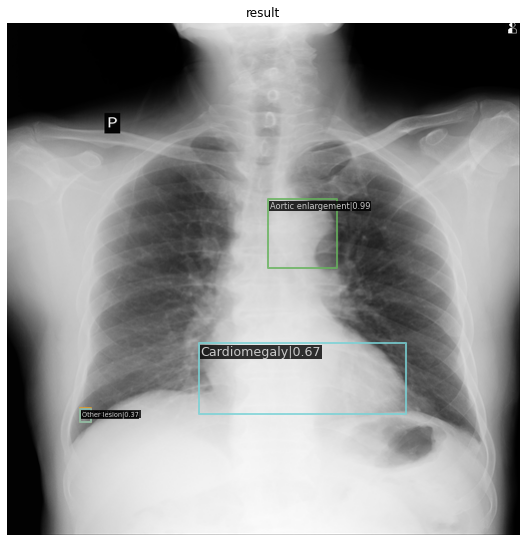

In [ ]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


In [ ]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,predictions[4].shape

(14, (3, 5), (0, 5), (1, 5), (1, 5), (0, 5))

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [ ]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.5 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)
    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        boxes = boxes[indexes]
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [ ]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

(3000, 2)

In [ ]:
submission.head()

,image_id,PredictionString
0,b9dcec0d41bcd2acb499745d5aeeaf08,8 0.8231 131.59634399414062 121.06913757324219...
1,ed8eee7061e062987cb2385657477236,14 1.0 0 0 1 1
2,b87fe4c1166680aa2e67644306baa246,0 0.9648 279.5615539550781 158.95660400390625 ...
3,3f6b6e7041b06528c5629fb7de92d61e,3 0.7230 203.95726013183594 234.1454315185547 ...
4,134214ffc7f507842719617ecd5bfc52,3 0.8941 149.16928100585938 241.9051971435547 ...


In [ ]:
submission.to_csv(f'/content/drive/MyDrive/project/vinBigData/submission/swin/mmdedtection_colab_swin_{EPOCHS}_1.csv', index=False)